In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = np.load("data/data.npz", allow_pickle=True)

train_data = data["train"]
test_data = data['test']

train_data.shape, test_data.shape

((5000, 2), (3000,))

In [58]:
train_data

(5000, 2)

In [5]:
# Convert each training to 1D array so can we can put that into a sklearn model
X = [sample.flatten() for sample in train_data[:, 0].tolist()]
y = train_data[:, 1].tolist()

/Users/macos/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

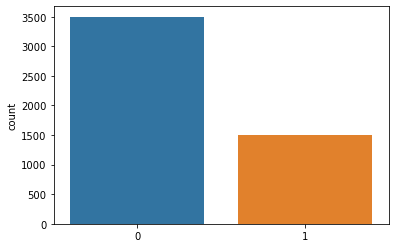

In [6]:
# Checking for any class imbalance
sns.countplot(y)

In [7]:
# Splitting the training set, and training & validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [8]:
X_train[0], y_train[0]

(array([-2.46225357, -0.04107225, -0.14181767, ..., -1.        ,
        -1.        , -1.        ]),
 0)

In [9]:
model = RandomForestClassifier(max_depth=7, n_estimators=200)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=200)

In [10]:
model.score(X_val, y_val)

0.985

In [11]:
# Converting each testing sample into 1D array
X_test = [sample.flatten() for sample in test_data.tolist()]

In [12]:
# Predicting the labels
predictions = model.predict(X_test)
predictions.shape

(3000,)

In [13]:
# Converting the predictions array into pandas dataset
submission = pd.DataFrame({"label":predictions})
submission

,label
0,0
1,1
2,0
3,1
4,0
...,...
2995,0
2996,1
2997,0
2998,0


In [14]:
submission.to_csv(os.path.join("assets", "submission.csv"), index=False)